<a href="https://colab.research.google.com/github/alezmartineza/Experimentos-Python/blob/main/EntrenamientoGradientBoostingdatosBancarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instalación y librerías
!pip install -q scikit-learn pandas matplotlib seaborn joblib

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8,5)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import joblib

In [ ]:
# 1.b Descargar y leer dataset (solo ejecutar si no subes el csv manualmente)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
zip_path = "bank-additional.zip"

if not os.path.exists("bank-additional-full.csv"):
    !wget -q --show-progress {url} -O {zip_path}
    !unzip -o {zip_path}

df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=';')
print("Shape:", df.shape)
display(df.head())

bank-additional.zip     [  <=>               ] 434.15K  1.70MB/s    in 0.2s    
Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  
Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# 2. Target y EDA rápido
df = df.copy()
df['target'] = df['y'].map({'yes':1, 'no':0})
df.drop(columns=['y'], inplace=True)

print("Distribución del target:")
print(df['target'].value_counts(normalize=True))

# Confirmar existencia de duration y eliminarla de predictores
print("Columnas que contienen 'duration'? ", [c for c in df.columns if 'duration' in c])
# No borramos la columna del dataframe (por si quieres inspeccionarla), pero la excluiremos de los predictores

Distribución del target:
target
0    0.887346
1    0.112654
Name: proportion, dtype: float64
Columnas que contienen 'duration'?  ['duration']


In [ ]:
# 2.b Definir predictores excluyendo 'duration'
all_predictors = [c for c in df.columns if c not in ['target', 'duration']]
print("Número de predictores (sin duration):", len(all_predictors))
print(all_predictors[:30])

Número de predictores (sin duration): 19
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [ ]:
# 3. Subconjuntos a probar (se excluye 'duration')
demographic_cols = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
campaign_cols = ['campaign', 'pdays', 'previous', 'poutcome']  # duration removida
# Filtrar por si alguna columna no existiera
demographic_cols = [c for c in demographic_cols if c in df.columns]
campaign_cols = [c for c in campaign_cols if c in df.columns]

print("Demographic cols:", demographic_cols)
print("Campaign cols (sin duration):", campaign_cols)

Demographic cols: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
Campaign cols (sin duration): ['campaign', 'pdays', 'previous', 'poutcome']


In [ ]:
# 4. Detectar categóricas y numéricas en el dataset completo (para usar en pipelines)
cat_cols_all = df[all_predictors].select_dtypes(include=['object']).columns.tolist()
num_cols_all = [c for c in all_predictors if c not in cat_cols_all]

from sklearn.exceptions import NotFittedError

def train_and_eval(feature_cols, random_state=42, return_model=False):
    X = df[feature_cols].copy()
    y = df['target'].values
    cat_sub = [c for c in feature_cols if c in cat_cols_all]
    num_sub = [c for c in feature_cols if c in num_cols_all]

    transformers = []
    if len(num_sub)>0:
        transformers.append(('num', StandardScaler(), num_sub))
    if len(cat_sub)>0:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), cat_sub))
    preproc = ColumnTransformer(transformers=transformers)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)

    model = Pipeline(steps=[
        ('pre', preproc),
        ('clf', GradientBoostingClassifier(random_state=random_state))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

    # Obtener nombres transformados para feature importance
    trans_names = []
    if len(num_sub) > 0:
        trans_names += num_sub
    if len(cat_sub) > 0:
        ohe = model.named_steps['pre'].named_transformers_['cat']
        cat_feature_names = ohe.get_feature_names_out(cat_sub).tolist()
        trans_names += cat_feature_names

    importances = model.named_steps['clf'].feature_importances_
    fi_series = pd.Series(importances, index=trans_names).sort_values(ascending=False)

    if return_model:
        return metrics, fi_series, model, (X_test, y_test, y_proba, y_pred)
    return metrics, fi_series

In [ ]:
# 5. Ejecutar experimentos
results = {}

# A: Demográficos
metrics_A, fi_A, modelA, dataA = train_and_eval(demographic_cols, return_model=True)
results['demographic'] = metrics_A

# B: Campaña (sin duration)
metrics_B, fi_B, modelB, dataB = train_and_eval(campaign_cols, return_model=True)
results['campaign'] = metrics_B

# C: Todas las variables (sin duration)
metrics_C, fi_C, modelC, dataC = train_and_eval(all_predictors, return_model=True)
results['all'] = metrics_C

# Mostrar tabla comparativa
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df[['accuracy','precision','recall','f1','roc_auc']]
display(metrics_df.round(4))

,accuracy,precision,recall,f1,roc_auc
demographic,0.8864,0.4412,0.0323,0.0602,0.6680
campaign,0.8984,0.6717,0.1918,0.2984,0.6421
all,0.9011,0.6728,0.2371,0.3506,0.8091


Top 25 feature importances (modelo sin duration):


,0
nr.employed,0.598806
pdays,0.087661
euribor3m,0.068507
cons.conf.idx,0.053506
poutcome_success,0.038529
month_oct,0.022760
age,0.019684
cons.price.idx,0.013582
poutcome_failure,0.013182
day_of_week_mon,0.011501


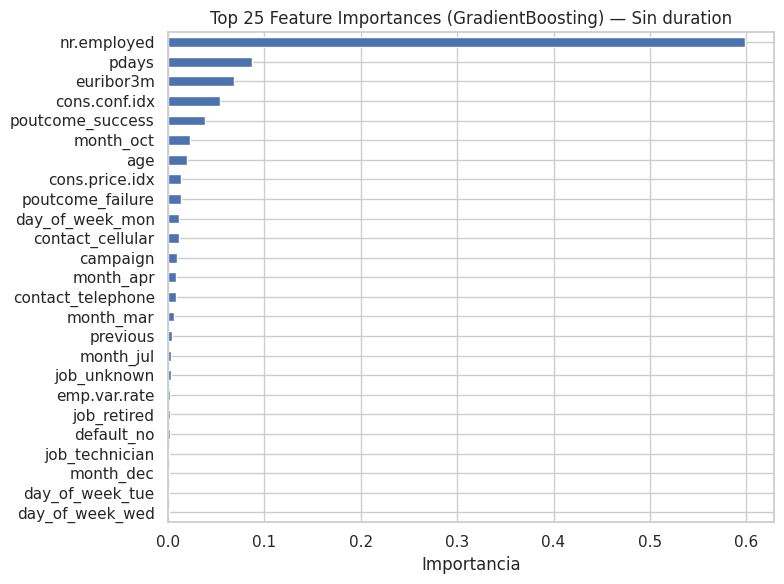

In [ ]:
# 6.a Top importancias (modelo con todas las variables sin duration)
top_n = 25
fi_top = fi_C.head(top_n)
print("Top", top_n, "feature importances (modelo sin duration):")
display(fi_top)

# Barra horizontal
plt.figure(figsize=(8,6))
fi_top.sort_values().plot(kind='barh', color='C0')
plt.title(f"Top {top_n} Feature Importances (GradientBoosting) — Sin duration")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

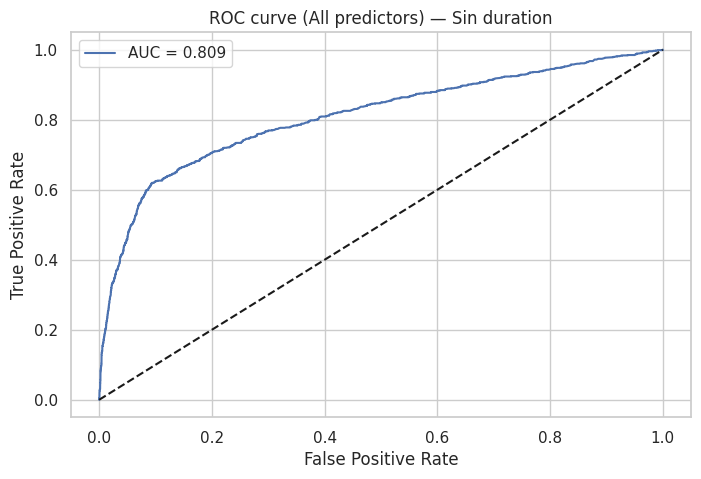

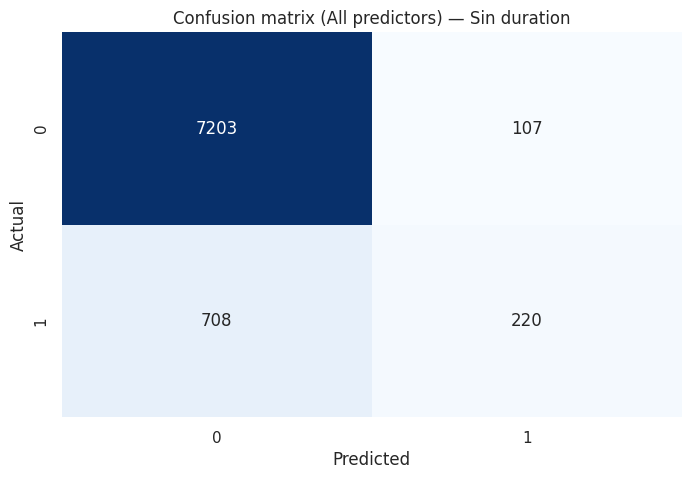

In [ ]:
# 6.b ROC y matriz de confusión para el modelo completo (sin duration)
X_test, y_test, y_proba, y_pred = dataC

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = metrics_C['roc_auc']
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (All predictors) — Sin duration")
plt.legend()
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix (All predictors) — Sin duration")
plt.show()

In [ ]:
# 6.c Guardar modelo y métricas (opcional)
joblib.dump(modelC, "gb_model_all_predictors_no_duration.joblib")
metrics_df.to_csv("metrics_comparison_no_duration.csv")
print("Modelo y métricas guardadas.")

Modelo y métricas guardadas.


## Explicación del Modelo en Contexto Real

Este ejercicio ha entrenado un modelo de clasificación (Gradient Boosting Classifier) para predecir si un cliente potencial se suscribirá a un depósito a plazo fijo ("target" = 1) o no ("target" = 0), basándonos en diversas características de los clientes y del contacto de marketing.

**¿Por qué se excluyó la columna 'duration'?**

Es importante notar que la columna 'duration' (duración del último contacto) fue excluida intencionalmente de los predictores. Aunque esta variable tiene una alta correlación con la variable objetivo, la información sobre la duración del contacto solo está disponible *después* de que el contacto se ha realizado. En un escenario de uso real, donde se busca predecir la probabilidad de suscripción *antes* de contactar al cliente para optimizar la campaña, no se tendría acceso a esta información. Excluir 'duration' asegura que el modelo sea útil para la planificación de campañas futuras.

**¿Para qué sirve?**

El objetivo principal es identificar a los clientes con mayor probabilidad de suscribirse a un depósito a plazo fijo. Esto permite a un banco o institución financiera optimizar sus campañas de marketing, dirigiendo sus esfuerzos y recursos hacia los clientes más receptivos.

**¿Funciona en producción o es solo clasificación/predicción?**

Sí, este tipo de modelo está diseñado para funcionar en producción. Es un modelo de **clasificación binaria**, ya que predice una de dos categorías posibles (sí o no se suscribe). La predicción es la probabilidad de que un cliente se suscriba, y en base a un umbral (por defecto 0.5), se clasifica como "sí" o "no".

**Ejemplo concreto de uso en el mundo real:**

Imagina que un banco quiere lanzar una nueva campaña para promocionar depósitos a plazo fijo. En lugar de contactar a todos los clientes al azar, pueden usar este modelo predictivo:

1. **Aplicar el modelo:** El banco toma los datos de sus clientes potenciales (edad, tipo de trabajo, estado civil, historial de contacto, etc.) y los introduce en el modelo entrenado.
2. **Obtener predicciones:** El modelo genera una probabilidad de suscripción para cada cliente.
3. **Segmentar clientes:** El banco puede entonces segmentar a sus clientes basándose en estas probabilidades. Por ejemplo, pueden identificar el 20% de los clientes con la mayor probabilidad de suscripción.
4. **Dirigir la campaña:** La campaña de marketing (llamadas telefónicas, correos electrónicos, etc.) se dirige principalmente a este grupo de alta probabilidad.

**Beneficios:**

* **Mayor eficiencia:** Se contacta a menos personas, reduciendo costos de marketing.
* **Mayor tasa de éxito:** Al enfocarte en clientes más propensos, la tasa de suscripción aumenta.
* **Mejor experiencia del cliente:** Se evita molestar a clientes con poca probabilidad de estar interesados.

En resumen, este ejercicio simula el proceso de construir un modelo predictivo para optimizar campañas de marketing en el sector bancario, utilizando datos históricos para predecir el comportamiento futuro de los clientes.